# Veidemann Doc2Vec
Creates Doc2Vec representations from websites harvested by the Veidemann harvester.


In [1]:
# Imports
import json
import re
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Generate Doc2Vec for websites.

In [3]:
data_path = "res/extracted_texts/veidemann/texts.ldjson"

def iter_urls(file):
    for line in file:
        j = json.loads(line)  # Each line contains a separate json entry
        if "discoveryPath" in j and "contentType" in j:
            if re.match("^R*$", j["discoveryPath"]) and re.match("text", j["contentType"], re.IGNORECASE):
                url, text = j["requestedUri"], j["text"].lower()
                if re.match("[^/]+//[^/]+\.no/?$", url):
                    yield url, text


class TaggedWebpageDocument(object):
    def __iter__(self):
        file = open(data_path)
        for url, text in iter_urls(file):
            words = [c for c in re.split(r"\s+", re.sub(r"[^\w\s]+", " ", text)) if len(c) > 0]
            yield TaggedDocument(words, [url])


documents = TaggedWebpageDocument()
model = Doc2Vec(documents, window=7, vector_size=128)

model.save("veidemann-homepages-doc2vec")

/home/rolv-arild/PycharmProjects/soc/venv/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [2]:
model = Doc2Vec.load("veidemann-doc2vec")

/home/rolv-arild/PycharmProjects/soc/venv/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
print(model.most_similar(positive=["nrk"]))
print(model.docvecs.most_similar(positive=["https://www.vg.no/"], topn=100))

[('tv2', 0.7433454394340515), ('vg', 0.6647576093673706), ('p3', 0.654242217540741), ('tv', 0.6508231163024902), ('aftenposten', 0.6507887840270996), ('p2', 0.6424126625061035), ('nrks', 0.6307368874549866), ('dagsrevyen', 0.5872172117233276), ('dagbladet', 0.5633687376976013), ('nyhetskanalen', 0.5556594133377075)]
[('https://www.dagbladet.no/', 0.8778731822967529), ('https://www.nettavisen.no/', 0.8664127588272095), ('https://sol.no/', 0.8376708030700684), ('https://www.tv2.no/', 0.825614333152771), ('https://www.seher.no/', 0.8110505938529968), ('https://www.nrk.no/', 0.8080971240997314), ('https://www.adressa.no/', 0.783088743686676), ('https://www.dagsavisen.no/', 0.7677257061004639), ('https://www.loggpaa.no/', 0.7613697052001953), ('https://www.itromso.no/', 0.7480970621109009), ('https://www.klartale.no/', 0.7442464828491211), ('https://www.abcnyheter.no/', 0.7430253028869629), ('https://www.dt.no/', 0.7429558038711548), ('https://www.aftenposten.no/', 0.7373539805412292), ('ht

/home/rolv-arild/PycharmProjects/soc/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


Run dimensionality reduction.

(39272, 128)


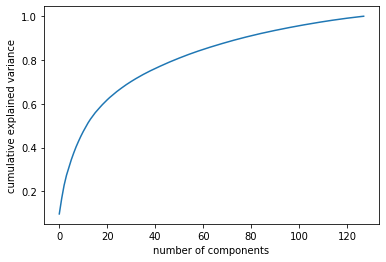

In [5]:
pca = PCA()

trans = pca.fit_transform(model.docvecs.vectors_docs)

print(trans.shape)

# Plot explained variance (information kept) vs number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [6]:
reduced = TSNE().fit_transform(trans)

np.save("veidemann-reduced.npy", reduced)

In [7]:
reduced = np.load("veidemann-reduced.npy")

Write to CSV for later analysis.

In [8]:
n_vec = model.docvecs.vectors_docs.shape[-1]

fw = open("all-homepages.csv", "w")
labels = ["url"] + \
         [f"r{i}" for i in range(reduced.shape[-1])] + \
         [f"v{i}" for i in range(n_vec)]
fw.write(",".join(labels) + "\n")
for tag, red, vec in zip(model.docvecs.doctags, reduced, model.docvecs.vectors_docs):
    tag = '"' + re.sub(r'\\', "/", tag) + '"'  # makes it weka compatible
    red = [str(r) for r in red]
    vec = [str(v) for v in vec]
    fw.write(",".join([tag] + red + vec) + "\n")

For converting to [TensorFlow embedding projector](https://projector.tensorflow.org/) compatible format

In [2]:
import pandas as pd

fn = "oos-doc2vec.csv"
csv = pd.read_csv(fn, index_col=False)

csv = csv.dropna(subset=[f"v{i}" for i in range(256)])
csv = csv.fillna("missing")

filt = "v\d+"
tsv1 = csv.filter(regex=filt)
tsv2 = csv.drop(tsv1.columns, axis=1)
tsv2 = tsv2.drop("text", axis=1)

tsv2 = tsv2.set_index("orig_url")

tsv1.to_csv(fn.replace(".csv", "-vec.tsv"), header=False, sep="\t", index=False)
tsv2.to_csv(fn.replace(".csv", "-meta.tsv"), sep="\t", index=True)

In [29]:
import numpy as np

def pandas2arff(df,filename,wekaname = "pandasdata",cleanstringdata=True,cleannan=True):
    """
    converts the pandas dataframe to a weka compatible file
    df: dataframe in pandas format
    filename: the filename you want the weka compatible file to be in
    wekaname: the name you want to give to the weka dataset (this will be visible to you when you open it in Weka)
    cleanstringdata: clean up data which may have spaces and replace with "_", special characters etc which seem to annoy Weka. 
                     To suppress this, set this to False
    cleannan: replaces all nan values with "?" which is Weka's standard for missing values. 
              To suppress this, set this to False
    """
    import re
    
    def cleanstring(s):
        if s!="?":
            return re.sub('[^A-Za-z0-9]+', "_", str(s))
        else:
            return "?"
            
    dfcopy = df #all cleaning operations get done on this copy

    
    if cleannan!=False:
        dfcopy = dfcopy.fillna(-999999999) #this is so that we can swap this out for "?"
        #this makes sure that certain numerical columns with missing values don't get stuck with "object" type
 
    f = open(filename,"w")
    arffList = []
    arffList.append("@relation " + wekaname + "\n")
    #look at each column's dtype. If it's an "object", make it "nominal" under Weka for now (can be changed in source for dates.. etc)
    for i in range(df.shape[1]):
        if dfcopy.dtypes[i]=='O' or (df.columns[i] in ["Class","CLASS","class"]):
            if cleannan!=False:
                dfcopy.iloc[:,i] = dfcopy.iloc[:,i].replace(to_replace=-999999999, value="?")
            if cleanstringdata!=False:
                dfcopy.iloc[:,i] = dfcopy.iloc[:,i].apply(cleanstring)
            _uniqueNominalVals = [str(_i) for _i in np.unique(dfcopy.iloc[:,i])]
            _uniqueNominalVals = ",".join(_uniqueNominalVals)
            _uniqueNominalVals = _uniqueNominalVals.replace("[","")
            _uniqueNominalVals = _uniqueNominalVals.replace("]","")
            _uniqueValuesString = "{" + _uniqueNominalVals +"}" 
            arffList.append("@attribute " + df.columns[i] + _uniqueValuesString + "\n")
        else:
            arffList.append("@attribute " + df.columns[i] + " real\n") 
            #even if it is an integer, let's just deal with it as a real number for now
    arffList.append("@data\n")           
    for i in range(dfcopy.shape[0]):#instances
        _instanceString = ""
        for j in range(df.shape[1]):#features
                if dfcopy.dtypes[j]=='O':
                    _instanceString+="\"" + str(dfcopy.iloc[i,j]) + "\""
                else:
                    _instanceString+=str(dfcopy.iloc[i,j])
                if j!=dfcopy.shape[1]-1:#if it's not the last feature, add a comma
                    _instanceString+=","
        _instanceString+="\n"
        if cleannan!=False:
            _instanceString = _instanceString.replace("-999999999.0","?") #for numeric missing values
            _instanceString = _instanceString.replace("\"?\"","?") #for categorical missing values
        arffList.append(_instanceString)
    f.writelines(arffList)
    f.close()
    del dfcopy
    return True

tsv2.reset_index().drop("text", axis=1).to_csv("oos.csv", index=False, quotechar="`")
# pandas2arff(tsv2.reset_index().drop("text", axis=1), fn.replace(".csv", ".arff"))